# Setup


In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from gensim.models import KeyedVectors
from modules.nlp import NLP

DATA_DIR = Path().cwd() / "data"

CHINA_HEX = '#ee1c25'
RUSSIA_HEX = '#1C3578'

nlp = NLP()

articles_df = pd.read_feather(DATA_DIR / "wikiarticles_seg_data.feather")

# Drop non-substantive article sections
section_titles_to_drop = ['Early life', 'Education',
                          'External links', 'Further reading', 'References', 'See also']
articles_df = articles_df[~articles_df['title'].isin(
    section_titles_to_drop)]

# Create a combined year and month column
articles_df['month'] = articles_df['month'].astype(str).str.zfill(2)
articles_df['year_month'] = articles_df['year'].astype(str) + '-' + articles_df['month']
articles_df['year_month'] = pd.to_datetime(articles_df['year_month'])

# Embeddings


**Pretrained embeddings:** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. Download from [this link](https://nlp.stanford.edu/data/glove.840B.300d.zip).


In [2]:
word_vectors = KeyedVectors.load_word2vec_format(
    DATA_DIR / "glove.840B.300d.txt", binary=False, no_header=True)

**Generating word embeddings**


In [3]:
# Remove sections without text
articles_df.dropna(subset=['text'], inplace=True)

# Tokenize text and remove stop words
tqdm.pandas(desc="Tokenizing article text")
articles_df['tokens'] = articles_df['text'].progress_apply(
    nlp.tokenize_text)

# Generate word embeddings
articles_df['weighted_embeddings'] = nlp.generate_tfidf_weighted_embeddings(
    articles_df['tokens'], word_vectors)

# Save embeddings
articles_df.to_feather(DATA_DIR / "wikiarticles_embeddings.feather")

Generating weighted embeddings: 100%|██████████| 225375/225375 [27:51<00:00, 134.83it/s]


**Calculating cosine similarities for different types of section**


In [24]:
articles_df = pd.read_feather(DATA_DIR / "wikiarticles_embeddings.feather")

# Calculate full article monthly similarities
article_monthly_similarities = articles_df.groupby('year_month').apply(
    nlp.calculate_grouped_similarities,
    figure_column='article_name',
    figure_1='Vladimir Putin',
    figure_2='Xi Jinping',
    embeddings_column='weighted_embeddings').interpolate(method='time')  # Interpolate missing values

# Calculate policy category monthly similarities
policy_monthly_similarities = articles_df.groupby('year_month').apply(
    nlp.calculate_grouped_similarities,
    figure_column='article_name',
    figure_1='Vladimir Putin',
    figure_2='Xi Jinping',
    embeddings_column='weighted_embeddings',
    category_column='category',
    category='policy').interpolate(method='time')  # Interpolate missing values

# Calculate leadership tenures monthly similarities
career_progression_monthly_similarities = articles_df.groupby('year_month').apply(
    nlp.calculate_grouped_similarities,
    figure_column='article_name',
    figure_1='Vladimir Putin',
    figure_2='Xi Jinping',
    embeddings_column='weighted_embeddings',
    category_column='category',
    category='Carreer Progression').interpolate(method='time')  # Interpolate missing values

# Calculate recognition category monthly similarities
recognition_monthly_similarities = articles_df.groupby('year_month').apply(
    nlp.calculate_grouped_similarities,
    figure_column='article_name',
    figure_1='Vladimir Putin',
    figure_2='Xi Jinping',
    embeddings_column='weighted_embeddings',
    category_column='category',
    category='Recognition').interpolate(method='time')  # Interpolate missing values

/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_91815/2266458145.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  article_monthly_similarities = articles_df.groupby('year_month').apply(
/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_91815/2266458145.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  policy_monthly_similarities = articles_df.groupby('year_month').apply(
/var/folde

In [9]:
articles_df['category'].unique()

array(['Origins', 'Carreer Progression', 'Leadership Tenures', 'policy',
       'Communications', 'Public Imaage', 'Personal Details',
       'Recognition', 'References', 'Assessment'], dtype=object)

**Plotting cosine similarities**


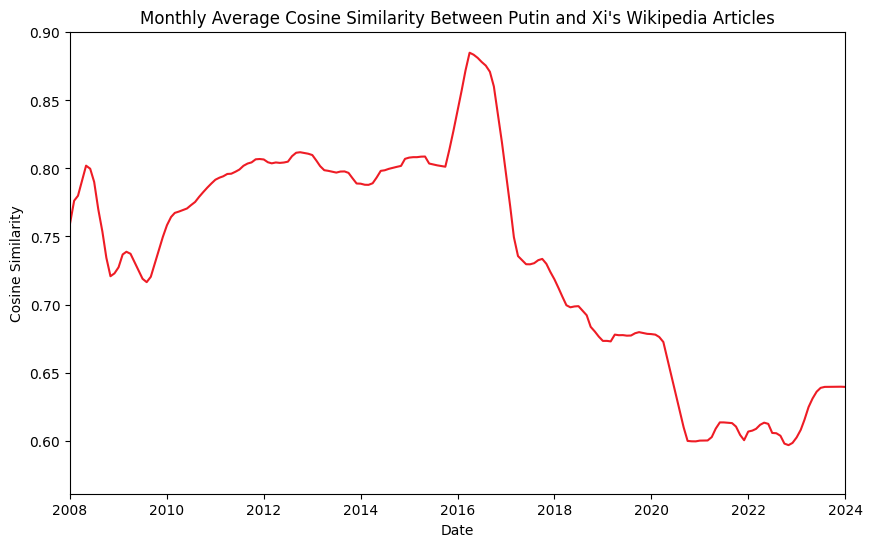

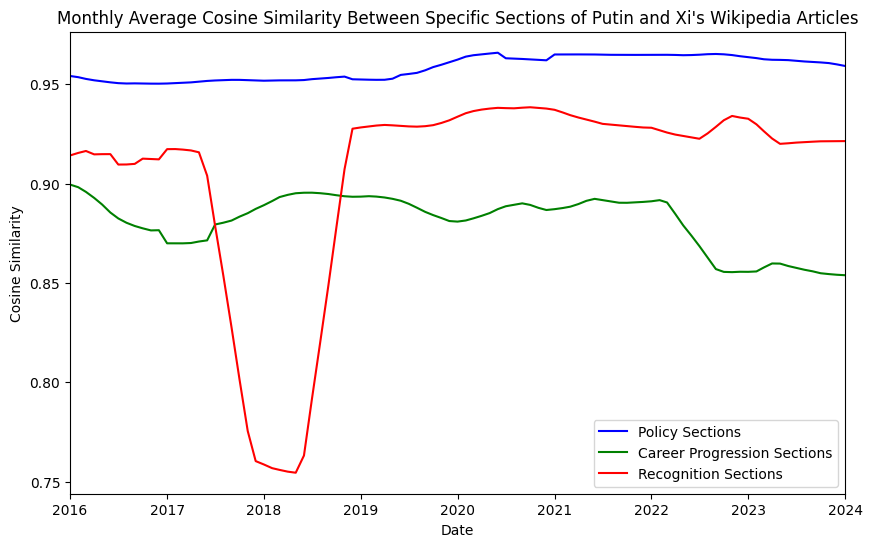

In [39]:
WINDOW = 6

plt.figure(figsize=(10, 6))
plt.plot(article_monthly_similarities.index,
         article_monthly_similarities.rolling(WINDOW).mean(), color=CHINA_HEX)

plt.xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2024-01-01'))
plt.title(
    "Monthly Average Cosine Similarity Between Putin and Xi's Wikipedia Articles")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(policy_monthly_similarities.index,
         policy_monthly_similarities.rolling(WINDOW).mean(), color='blue', label="Policy Sections")
plt.plot(career_progression_monthly_similarities.index,
         career_progression_monthly_similarities.rolling(WINDOW).mean(), color='green', label="Career Progression Sections")
plt.plot(recognition_monthly_similarities.index,
         recognition_monthly_similarities.rolling(WINDOW).mean(), color='red', label="Recognition Sections")

plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01'))
plt.title("Monthly Average Cosine Similarity Between Specific Sections of Putin and Xi's Wikipedia Articles")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.legend()

plt.show()